In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
from scipy.stats import zscore
from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/MVG_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k_hyperalignment/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'valid_source', 'valid_target']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

def get_section_types(wav_names):
    section_types = []
    for wav_name in wav_names:
        if 'section_00' in wav_name:
            section_types.append(0)
        elif 'section_01' in wav_name:
            section_types.append(1)
        else:
            section_types.append(2)
    
    return section_types

section_types = get_section_types(wav_names)

# evaluation

## calc MVG (multivariate Gaussian)

In [10]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    
    mean = ext_data['train']['features'].mean(axis=0)
    cov_estimator = LedoitWolf()
    cov_estimator.fit(ext_data['train']['features'])
    cov = cov_estimator.covariance_
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov

com.toc()

elapsed time: 19.174058437 [sec]


In [11]:
MVG[machine_type]['cov'].shape

(3072, 3072)

## estimate

2021-03-30 22:34:22,606 - 00_train.py - INFO - fan valid_source AUC : 0.4906555555555556
2021-03-30 22:34:22,613 - 00_train.py - INFO - fan valid_target AUC : 0.4962777777777778


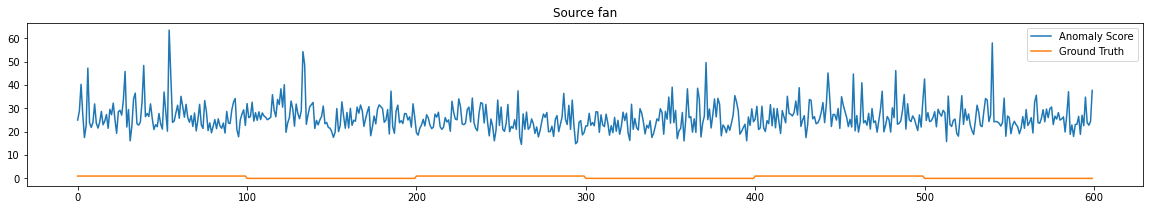

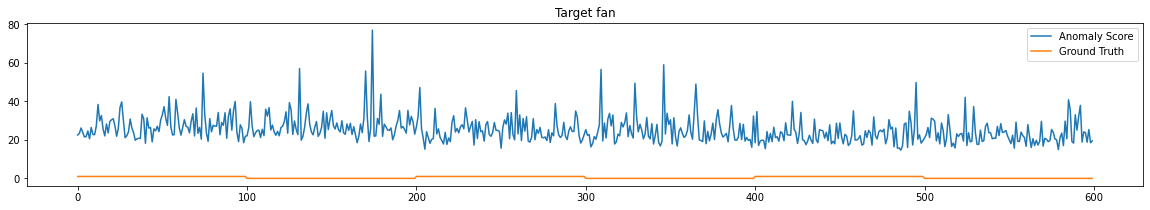

2021-03-30 22:34:27,362 - 00_train.py - INFO - gearbox valid_source AUC : 0.4275514518823521
2021-03-30 22:34:27,364 - 00_train.py - INFO - gearbox valid_target AUC : 0.33773501309909076


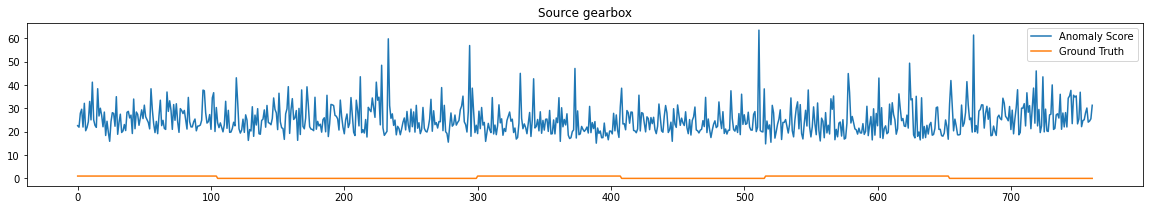

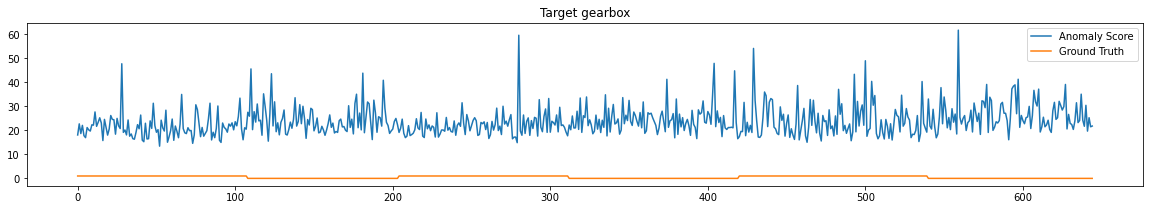

2021-03-30 22:34:31,423 - 00_train.py - INFO - pump valid_source AUC : 0.4221666666666667
2021-03-30 22:34:31,425 - 00_train.py - INFO - pump valid_target AUC : 0.4711444444444444


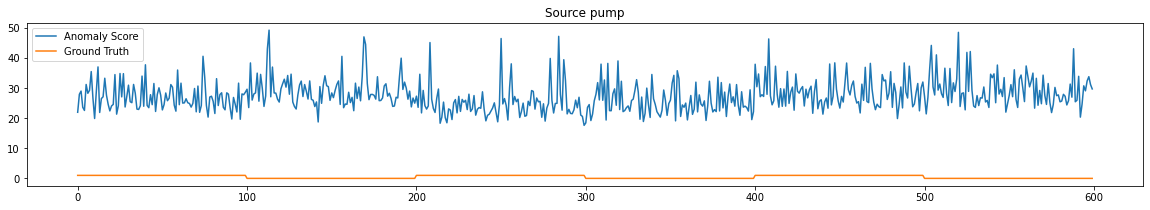

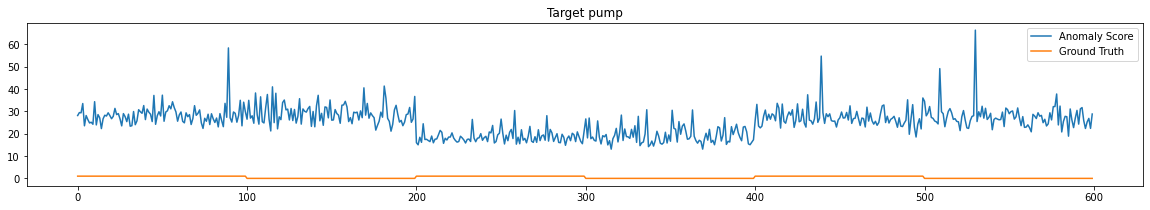

2021-03-30 22:34:35,355 - 00_train.py - INFO - slider valid_source AUC : 0.3935697500534074
2021-03-30 22:34:35,357 - 00_train.py - INFO - slider valid_target AUC : 0.4776931567328918


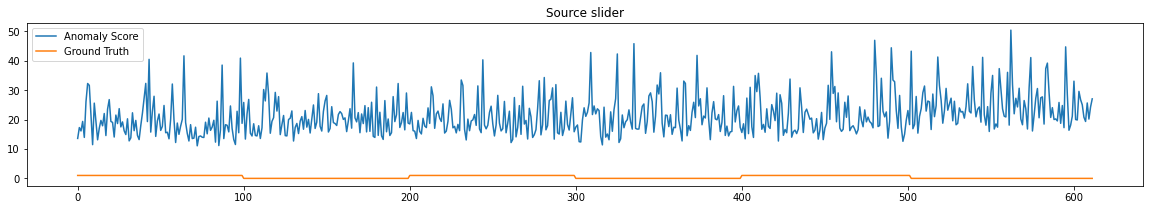

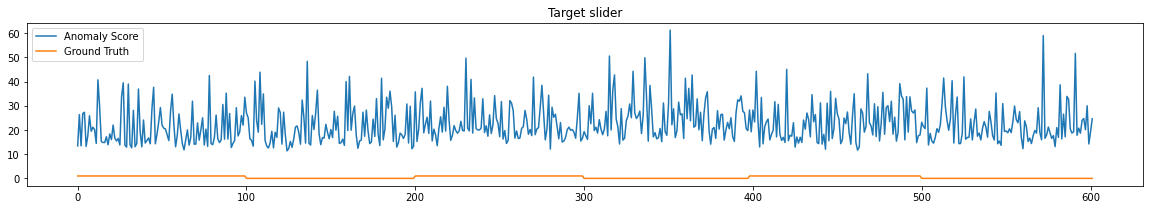

2021-03-30 22:34:39,630 - 00_train.py - INFO - ToyCar valid_source AUC : 0.5486444444444445
2021-03-30 22:34:39,633 - 00_train.py - INFO - ToyCar valid_target AUC : 0.4820111111111111


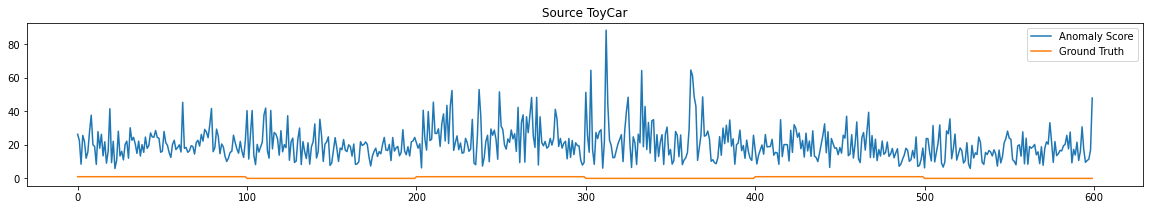

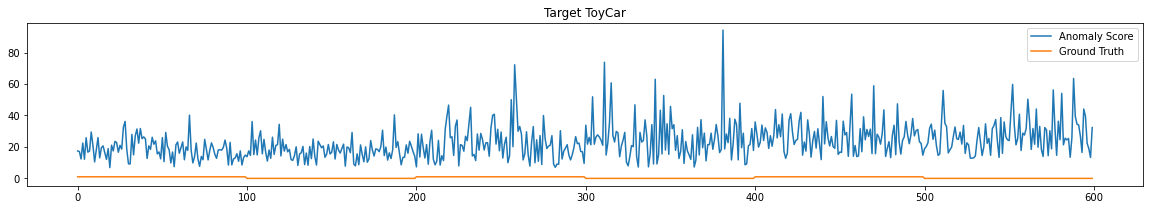

2021-03-30 22:34:43,936 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.49448888888888887
2021-03-30 22:34:43,939 - 00_train.py - INFO - ToyTrain valid_target AUC : 0.4740333333333333


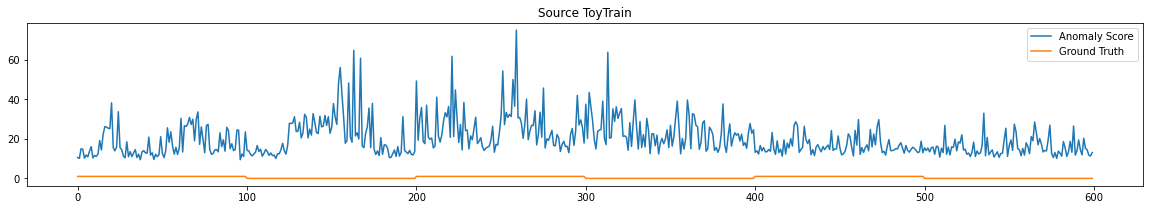

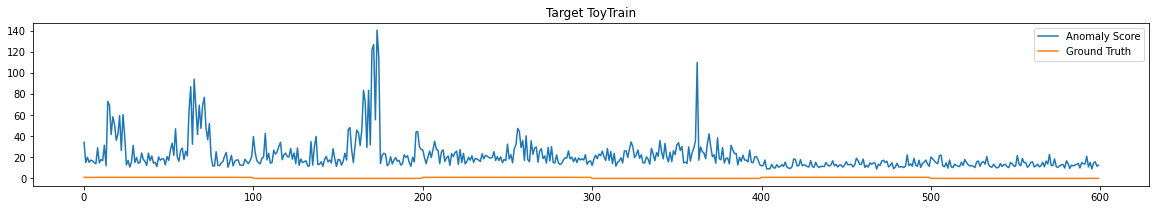

2021-03-30 22:34:48,032 - 00_train.py - INFO - valve valid_source AUC : 0.6226777777777778
2021-03-30 22:34:48,035 - 00_train.py - INFO - valve valid_target AUC : 0.5666333333333333


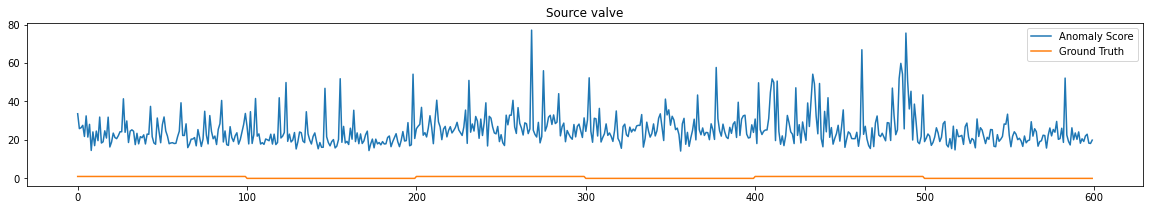

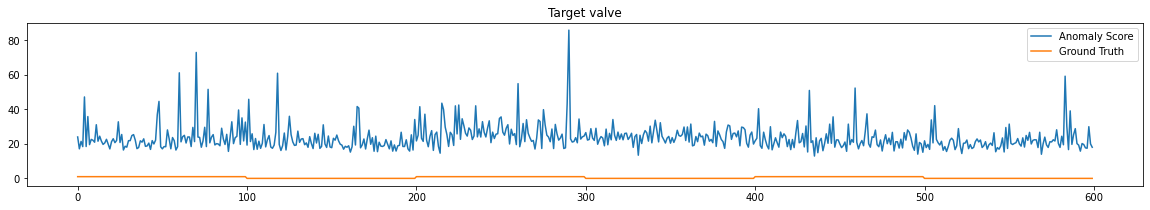

In [12]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [13]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [14]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

GaussianMixture(n_components=3, random_state=42)

In [15]:
gmm.bic(ext_data['train']['features'])

9817075.004331082

In [16]:
pred = gmm.predict(ext_data['train']['features'])

(array([1351.,    0.,    0.,    0.,    0.,  924.,    0.,    0.,    0.,
         733.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

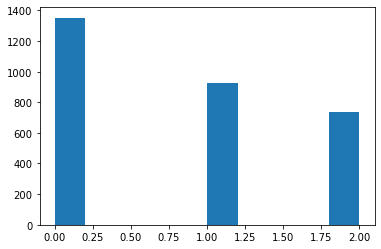

In [17]:
plt.hist(pred)

In [18]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [19]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [20]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

2021-03-30 22:35:36,579 - 00_train.py - INFO - fan valid_source AUC : 0.5258444444444444
2021-03-30 22:35:36,581 - 00_train.py - INFO - fan valid_target AUC : 0.49562222222222224
2021-03-30 22:35:39,454 - 00_train.py - INFO - gearbox valid_source AUC : 0.43923167037522265
2021-03-30 22:35:39,456 - 00_train.py - INFO - gearbox valid_target AUC : 0.4116004006780705
2021-03-30 22:35:41,979 - 00_train.py - INFO - pump valid_source AUC : 0.4655111111111111
2021-03-30 22:35:41,983 - 00_train.py - INFO - pump valid_target AUC : 0.5386
2021-03-30 22:35:44,421 - 00_train.py - INFO - slider valid_source AUC : 0.40424054689168987
2021-03-30 22:35:44,423 - 00_train.py - INFO - slider valid_target AUC : 0.4382560706401766
2021-03-30 22:35:46,700 - 00_train.py - INFO - ToyCar valid_source AUC : 0.5121666666666667
2021-03-30 22:35:46,702 - 00_train.py - INFO - ToyCar valid_target AUC : 0.5279777777777779
2021-03-30 22:35:48,903 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.4019888888888889
202

In [21]:
gmm_section_types = gmm.predict(feats)

NameError: name 'feats' is not defined

In [ ]:
sns.distplot(section_types)

In [ ]:
sns.displot(gmm_section_types)